In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import os.path

index_list = [
    "loadtest-webrtc-preliminary-mediasoup-2p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-2p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-5p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-5p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-6p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-6p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-7p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-7p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-8p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-8p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-10p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-10p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-3p-10s-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-3p-10s-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-3p-40s-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-3p-40s-c5xlarge-final"
]

node_types = ["browseremulator", "masternode", "medianode"]

seconds_per_fragment = 17

In [62]:
df_list = [pd.read_csv(f"dfs/{x}.csv")
           for x in index_list if os.path.isfile(f"dfs/{x}.csv")]
for df_user in df_list:
    df_user["@timestamp"] = pd.to_datetime(df_user["@timestamp"])
    df_user["cut_index"] = df_user["cut_index"] * seconds_per_fragment


(0.0, 1.0)

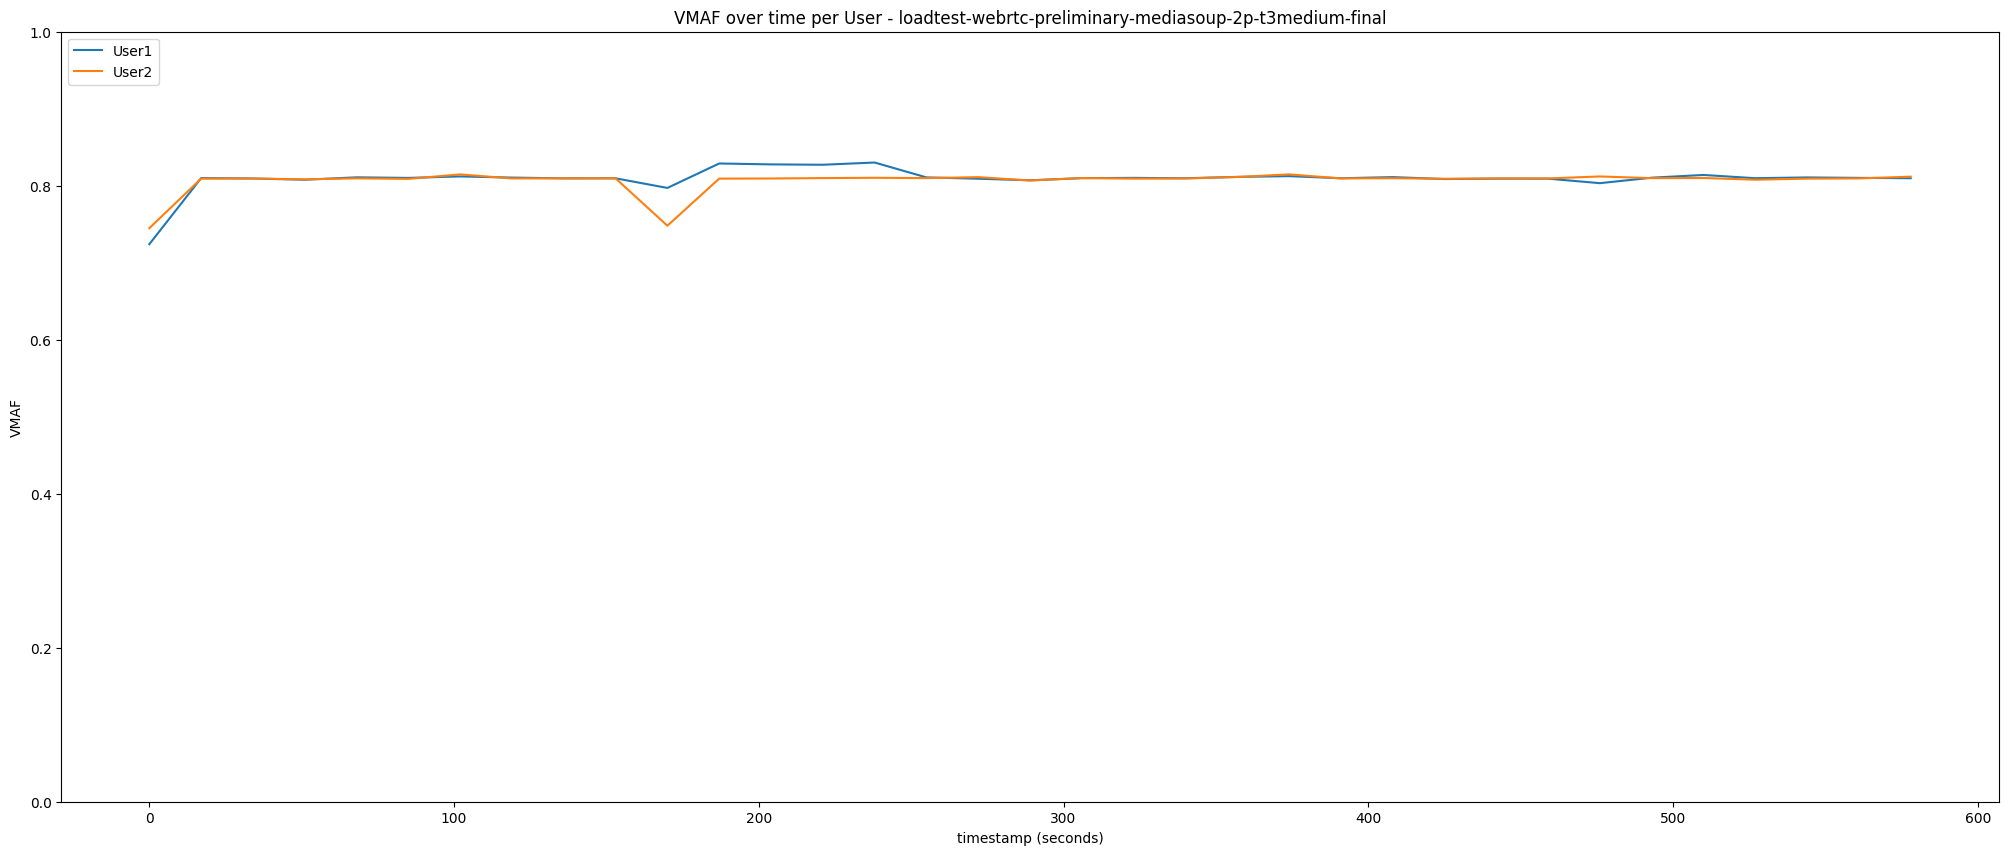

In [63]:
plt.rcParams['figure.figsize'] = [25, 10]
case = 0
df_user = df_list[case]
for user in df_user.userFrom.unique():
    df_user1 = df_user[df_user.userFrom == user]
    plt.plot(df_user1["cut_index"], df_user1["vmaf"], label=user)

plt.title("VMAF over time per User - " + index_list[case])
plt.xlabel("timestamp (seconds)")
plt.ylabel("VMAF")
plt.legend(loc="upper left")
plt.ylim(0, 1)


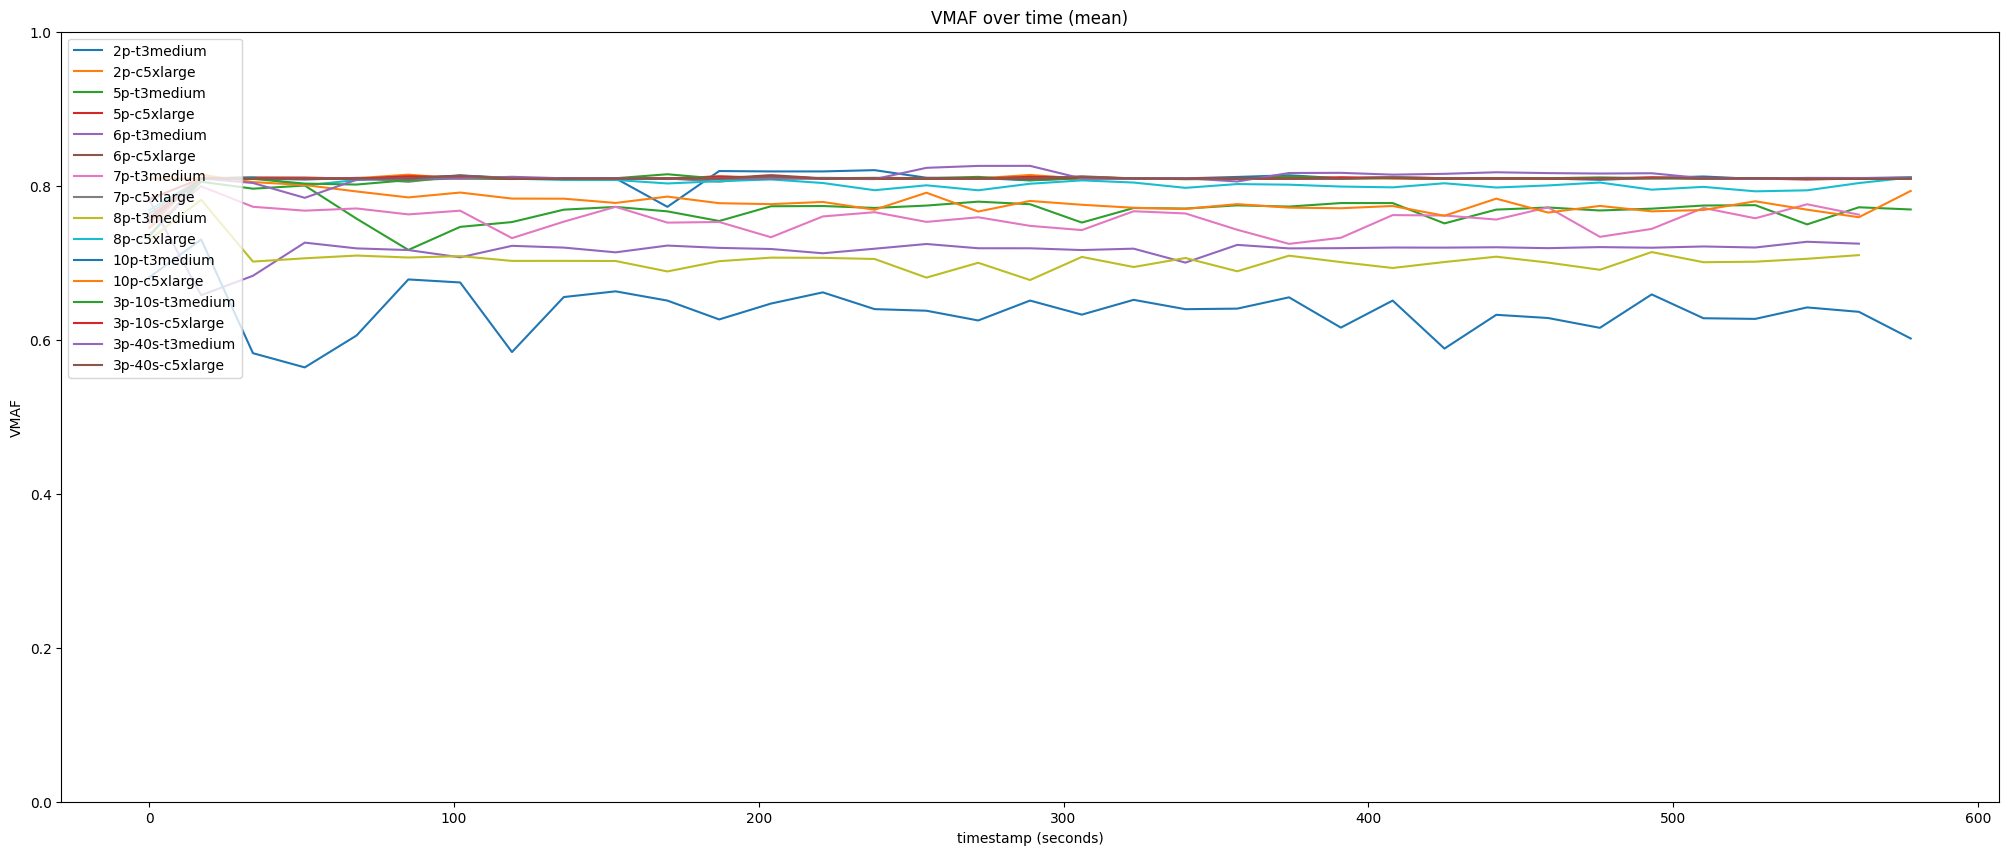

In [64]:
plt.rcParams['figure.figsize'] = [25, 10]


for i, df_tmp in enumerate(df_list):
    df_mean = df_tmp.groupby(["cut_index"]).mean()
    plot_name = index_list[i][38:-6]
    if not df_mean.empty:
        plt.plot(df_mean.index, df_mean["vmaf"], label=plot_name)

plt.title("VMAF over time (mean)")
plt.xlabel("timestamp (seconds)")
plt.ylabel("VMAF")
plt.ylim(0, 1)
plt.legend(loc="upper left")


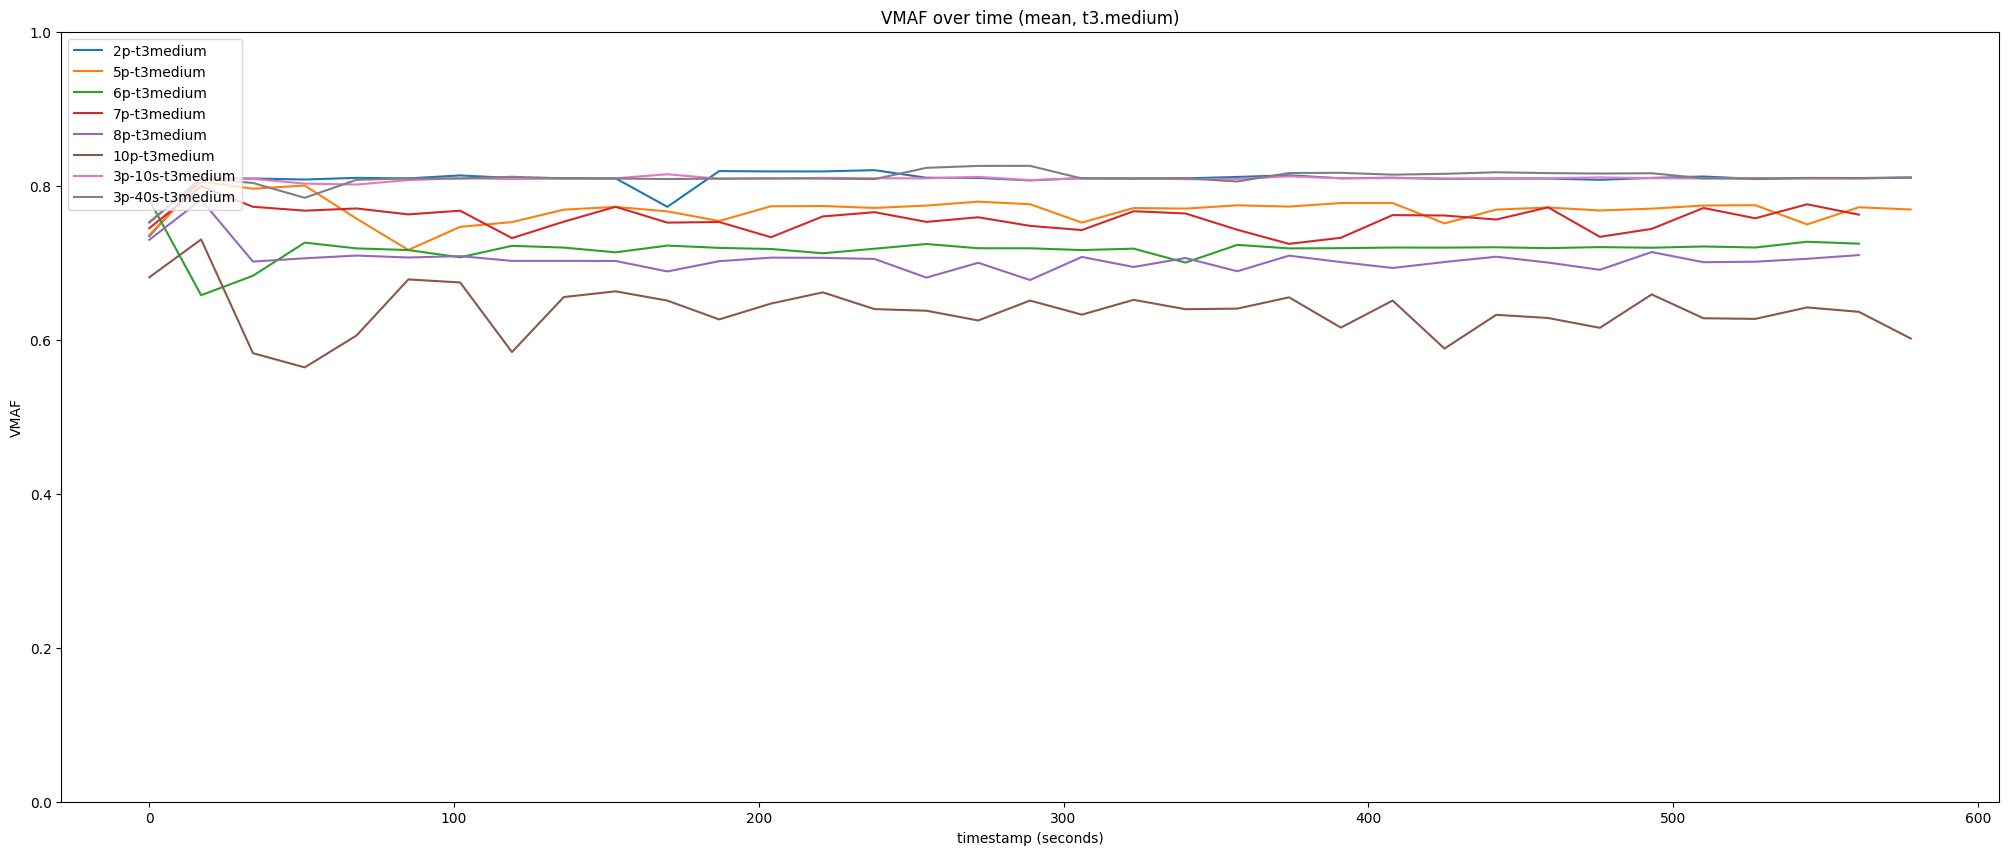

In [65]:
plt.rcParams['figure.figsize'] = [25, 10]


for i, df_tmp in enumerate(df_list):
    if (i % 2 == 0):
        df_mean = df_tmp.groupby(["cut_index"]).mean()
        plot_name = index_list[i][38:-6]
        if not df_mean.empty:
            plt.plot(df_mean.index, df_mean["vmaf"], label=plot_name)

plt.title("VMAF over time (mean, t3.medium)")
plt.xlabel("timestamp (seconds)")
plt.ylabel("VMAF")
plt.ylim(0, 1)
plt.legend(loc="upper left")


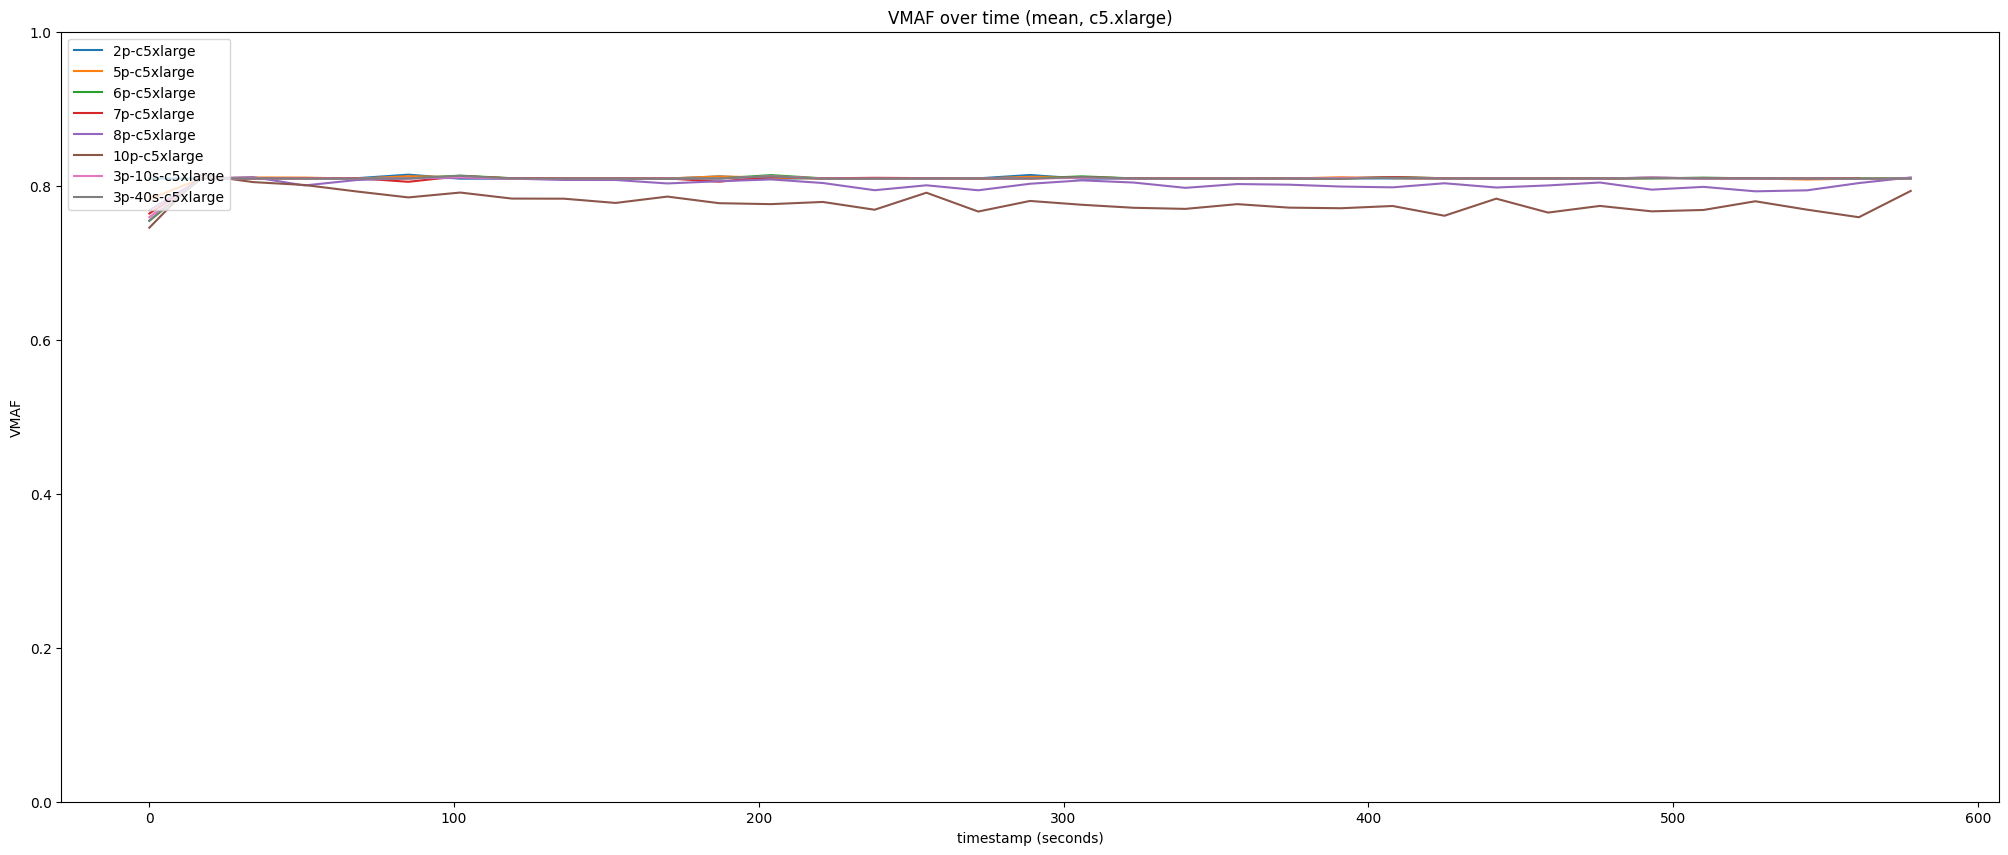

In [66]:
plt.rcParams['figure.figsize'] = [25, 10]


for i, df_tmp in enumerate(df_list):
    if (i % 2 != 0):
        df_mean = df_tmp.groupby(["cut_index"]).mean()
        plot_name = index_list[i][38:-6]
        if not df_mean.empty:
            plt.plot(df_mean.index, df_mean["vmaf"], label=plot_name)

plt.title("VMAF over time (mean, c5.xlarge)")
plt.xlabel("timestamp (seconds)")
plt.ylabel("VMAF")
plt.ylim(0, 1)
plt.legend(loc="upper left")


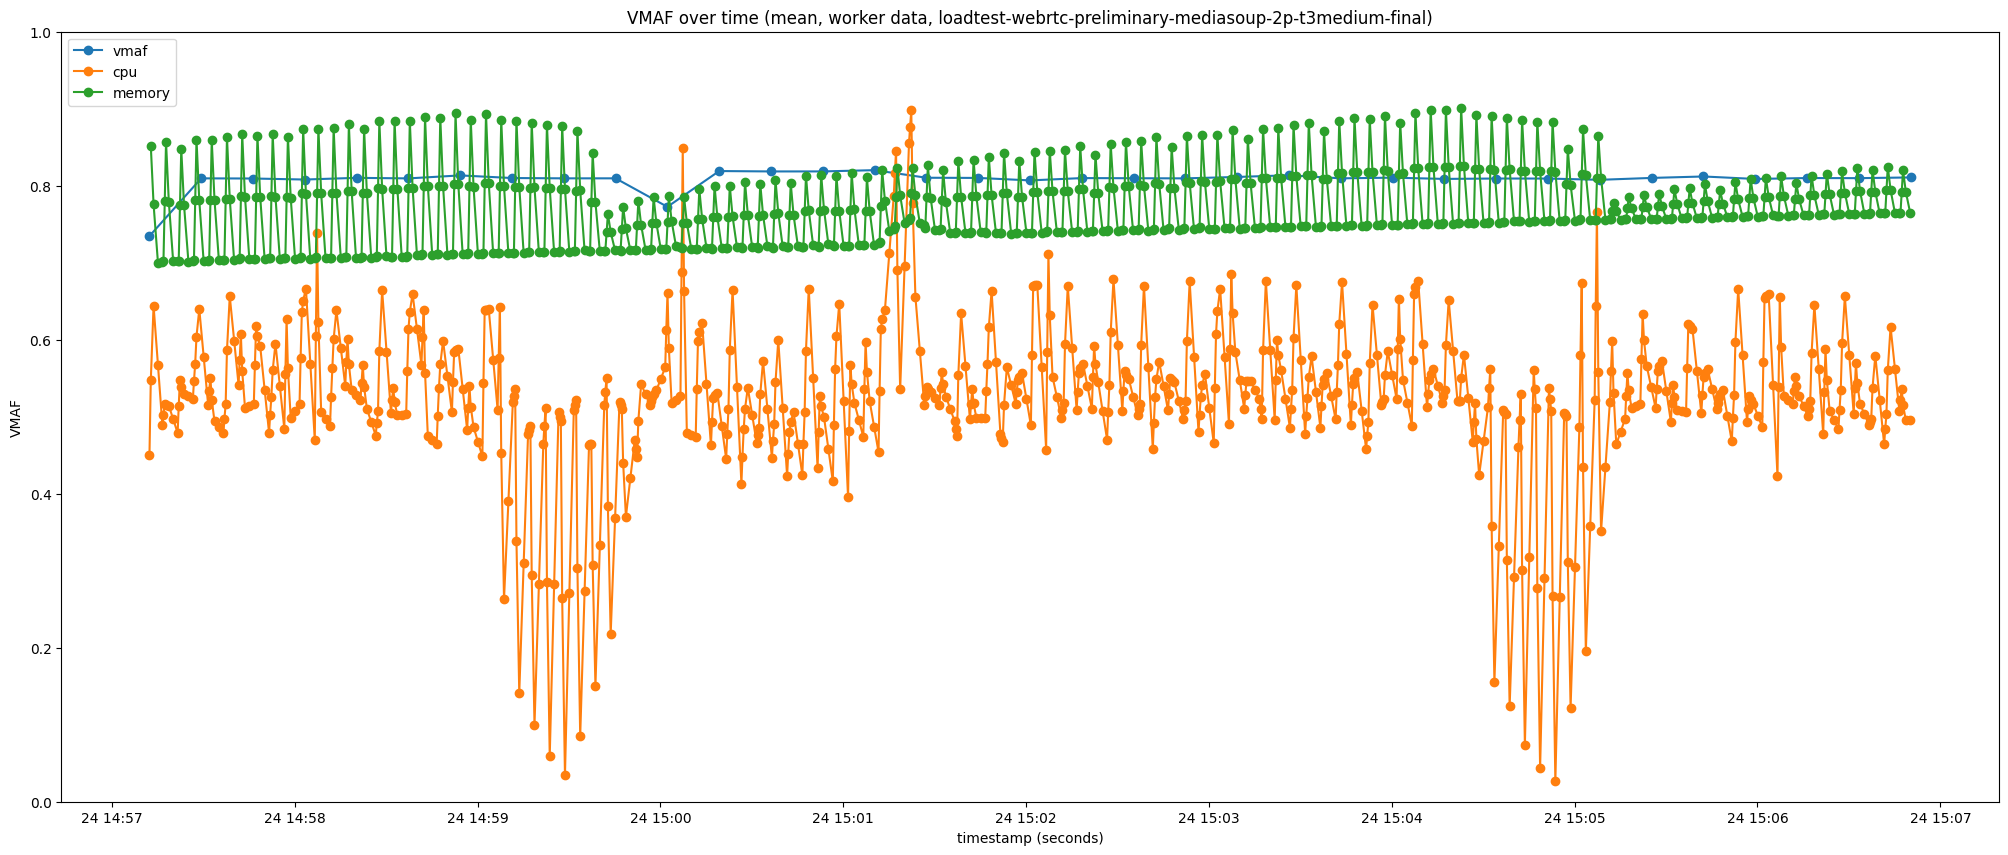

In [79]:
plt.rcParams['figure.figsize'] = [25, 10]

index = 0
index_name = index_list[index]

df_tmp = df_list[index].groupby("cut_index").agg({"@timestamp": "first", "vmaf": "mean"})
df_node = pd.read_csv(f"dfs/{index_name}-browseremulator.csv")
df_node["@timestamp"] = pd.to_datetime(df_node["@timestamp"])
df = pd.concat([df_tmp, df_node])

plt.plot(df["@timestamp"], df["vmaf"], label="vmaf", marker = "o")
plt.plot(df["@timestamp"], df["cpu"].interpolate(method="linear"), label="cpu", marker = "o")
plt.plot(df["@timestamp"], df["memory"].interpolate(method="linear"), label="memory", marker = "o")

plt.title(f"VMAF over time (mean, worker data, {index_name})")
plt.xlabel("timestamp (seconds)")
plt.ylabel("VMAF")
plt.ylim(0, 1)
plt.legend(loc="upper left")
